# Tensorflow tensor datastructure to build the same - with AutoDifferenciation

In [34]:
# All posible imports
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [35]:
# Utility function to plot 3D Graphs
def plot_3d(comp, title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(title)
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [36]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed
tf.random.set_seed(3)

# Generating X with 3 dimentions
X = tf.random.uniform((n, inputs_dimensions), -1, 1)

# Generating the value of the y_true
weights_true = tf.constant([[2., -5., 9.], [-1., 4., -5.]], dtype=tf.float32)
bias_true = tf.constant([[1], [-1]], dtype=tf.float32)

y_true = tf.matmul(9 * X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)

print('Sample Value for X:' + str(X[:3]))
print('Sample Value for y:'+ str(y_true[:3]))

Sample Value for X:tf.Tensor(
[[-0.73267365  0.13570619 -0.00733662]
 [-0.9662695   0.00908351  0.4974625 ]
 [-0.73932624 -0.32877016  0.30385542]], shape=(3, 3), dtype=float32)
Sample Value for y:tf.Tensor(
[[  7.628318   -3.8585553]
 [ 40.346657  -22.020931 ]
 [ 16.35329    -8.277992 ]], shape=(3, 2), dtype=float32)


# Plotting the data in a 3-Dimentional Plane

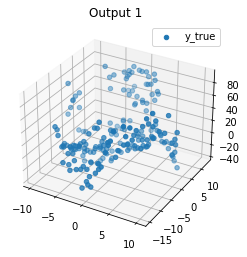

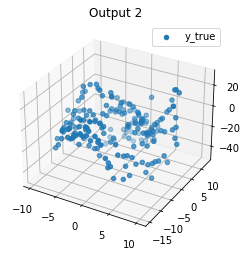

In [37]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [38]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print("Number of inputs"+str(inputs))
print("Number of outputs"+str(outputs))

Number of inputs3
Number of outputs2


# Layers of neural network

In [39]:
class Layer:
    def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        # Init layer with random weights and bias
        self.weights = tf.Variable(tf.random.uniform((num_input_nodes, num_output_nodes), -1, 1), name='Layer ({}, {}) Weights'.format(num_input_nodes, num_output_nodes))
        self.bias = tf.Variable(tf.random.uniform((1, 1), -1, 1), name='Layer ({}, {}) Bias'.format(num_input_nodes, num_output_nodes))
        self.X = tf.zeros([num_input_nodes])
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X
        self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    def backward(self, dJdW, dJdb):
        self.dJdW = dJdW
        self.dJdb = dJdb

    # Update weight and bias
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.weights = tf.Variable(self.weights)
        self.bias = self.bias - lr * self.dJdb
        self.bias = tf.Variable(self.bias)

# Activation Function RELU

In [40]:
class Relu:
    def __init__(self):
        self.input = tf.constant([], dtype=tf.float32)

    def forward(self, input):
        self.input = input
        self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
        return self.output
  
    def backward(self, upstream_gradient):
        return
  
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

# Neural Net Model

In [41]:
class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
        self.layers = []
        for i in range(len(layers[:-1])):
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        # Print network architecture for debugging
        print('Neural Net Architecture:')
        for i, layer in enumerate(self.layers):
            print('Layer {}'.format(i))
            print(layer)
    print()

    def forward(self, inputs):
        curr_out = inputs
        for l in self.layers:
            curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true, tape):
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred))

        for layer in reversed(self.layers):
            [dJdW, dJdb] = tape.gradient(error, [layer.weights, layer.bias])
            layer.backward(dJdW, dJdb)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)
  
    # Training loop pochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            with tf.GradientTape(persistent=True) as tape:
                y_pred = self.forward(X)
                self.backward(y_pred, y_true, tape)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Mean Squared Error

In [42]:
# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Training with Activation function RELU

In [43]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
Layer 0
Layer 1
Layer 2
Error:  876.0688
Error:  872.04944
Error:  868.3442
Error:  864.92883
Error:  861.78015
Error:  858.87866
Error:  856.20526
Error:  853.74133
Error:  851.4693
Error:  849.375
Error:  847.44495
Error:  845.66534
Error:  844.021
Error:  842.5053
Error:  841.1078
Error:  839.8184
Error:  838.6295
Error:  837.53235
Error:  836.5184
Error:  835.57764
Error:  834.70435
Error:  833.8951
Error:  833.1415
Error:  832.4418
Error:  831.7779
Error:  831.1319
Error:  830.5405
Error:  829.9744
Error:  829.4324
Error:  828.9131
Error:  828.3828
Error:  827.7952
Error:  827.0721
Error:  826.0977
Error:  824.5669
Error:  822.0274
Error:  817.13257
Error:  806.3954
Error:  780.66046
Error:  710.47375
Error:  665.972
Error:  831.69977
Error:  804.0442
Error:  723.89404
Error:  618.6288
Error:  787.125
Error:  708.3076
Error:  549.4603
Error:  507.21143
Error:  696.9021
Error:  607.7093
Error:  594.2456
Error:  593.6651
Error:  593.48456
Error:  593.4475
Er

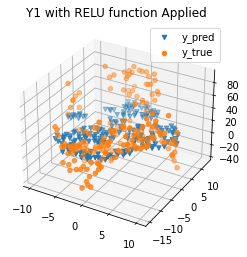

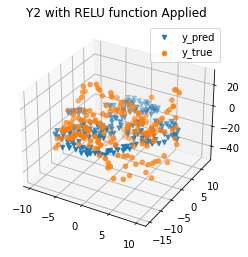

In [44]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])

# Training without Activation function RELU

In [45]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation=None)
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
Layer 0
Layer 1
Layer 2
Error:  884.46063
Error:  853.652
Error:  820.93835
Error:  744.4188
Error:  604.28094
Error:  572.91064
Error:  590.9764
Error:  535.64185
Error:  534.53796
Error:  531.2522
Error:  530.9663
Error:  529.6921
Error:  529.4556
Error:  528.90533
Error:  528.74194
Error:  528.48834
Error:  528.38556
Error:  528.2616
Error:  528.1992
Error:  528.135
Error:  528.09705
Error:  528.06134
Error:  528.03784
Error:  528.01685
Error:  528.0016
Error:  527.9886
Error:  527.97845
Error:  527.9696
Error:  527.9625
Error:  527.9564
Error:  527.9515
Error:  527.947
Error:  527.94324
Error:  527.94006
Error:  527.9372
Error:  527.9347
Error:  527.9326
Error:  527.9306
Error:  527.92896
Error:  527.92737
Error:  527.92615
Error:  527.9252
Error:  527.92395
Error:  527.923
Error:  527.92194
Error:  527.92145
Error:  527.9208
Error:  527.92004
Error:  527.9191
Error:  527.91876
Error:  527.9183
Error:  527.918
Error:  527.9174
Error:  527.9171
Error:  527.9

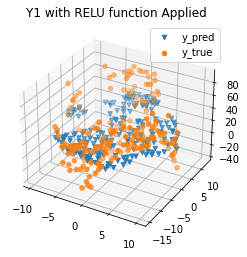

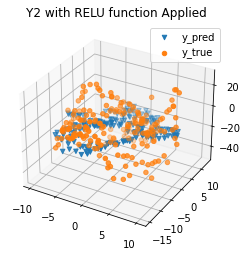

In [46]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])